In [12]:
# Source: https://wiseodd.github.io/techblog/2016/06/13/parallel-monte-carlo/

import numpy as np
import pandas as pd

nFact= 5
x = np.random.normal(size=(1000, nFact))
x.shape

(1000, 5)

In [13]:
x_df = pd.DataFrame(x)
x_df['const'] = 1
x_df.head()

,0,1,2,3,4,const
0,-0.369001,-0.036879,-0.056321,1.588101,0.668590,1
1,0.995490,-0.810685,-0.917220,-1.363253,0.587433,1
2,0.671004,0.149767,-1.772313,-0.459589,-0.719039,1
3,1.544441,1.492151,0.249404,0.211887,0.942992,1
4,-1.604987,0.393802,-1.372647,-0.224569,1.659159,1


In [14]:
x_df = x_df.loc[:, ['const'] + list(range(nFact))]
x_df.head()

,const,0,1,2,3,4
0,1,-0.369001,-0.036879,-0.056321,1.588101,0.668590
1,1,0.995490,-0.810685,-0.917220,-1.363253,0.587433
2,1,0.671004,0.149767,-1.772313,-0.459589,-0.719039
3,1,1.544441,1.492151,0.249404,0.211887,0.942992
4,1,-1.604987,0.393802,-1.372647,-0.224569,1.659159


In [15]:
x_df[10] = x_df[0] * x_df[1]
x_df[23] = x_df[2] * x_df[3]
x_df.head()

,const,0,1,2,3,4,10,23
0,1,-0.369001,-0.036879,-0.056321,1.588101,0.668590,0.013608,-0.089443
1,1,0.995490,-0.810685,-0.917220,-1.363253,0.587433,-0.807029,1.250402
2,1,0.671004,0.149767,-1.772313,-0.459589,-0.719039,0.100494,0.814536
3,1,1.544441,1.492151,0.249404,0.211887,0.942992,2.304538,0.052845
4,1,-1.604987,0.393802,-1.372647,-0.224569,1.659159,-0.632048,0.308254


In [18]:
# column 4 does not 
coefs = np.random.uniform(0, 1, size=x_df.shape[1])
coefs[nFact] = 0.0
coefs

array([0.28521794, 0.3155912 , 0.85748084, 0.04835334, 0.8019202 ,
       0.        , 0.68009235, 0.00958181])

In [19]:
log_odds = x_df.values.dot(coefs)
probs = 1/(1+ np.exp(-log_odds))
print(np.min(probs), np.max(probs))

0.006276336182542888 0.9982275784100622


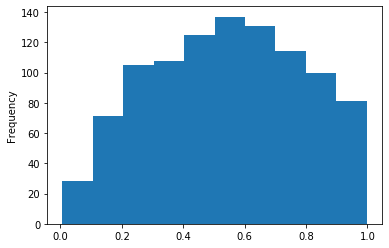

In [20]:
pd.Series(probs).plot.hist()

In [22]:
# generate outcome
val = np.random.binomial(1, probs)
pd.Series(val).describe()

count    1000.000000
mean        0.562000
std         0.496389
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64

In [27]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_df.loc[:,['const'] + [0,1,2,3,4, 10,23]], val)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [35]:
rf.feature_importances_.copy()

array([0.        , 0.12763053, 0.16867516, 0.11460576, 0.21506728,
       0.11196012, 0.15597949, 0.10608166])

# Let's put it together

In [36]:
res = None
select_list = ['const'] + [0,1,2,3,4]
nFact = 5

for i in range(1000):
    np.random.seed(i)
    x = np.random.normal(size=(2000, nFact))
    x_df = pd.DataFrame(x)
    x_df['const'] = 1
    x_df = x_df.loc[:, ['const'] + list(range(nFact))]
    x_df[10] = x_df[0] * x_df[1]
    x_df[23] = x_df[2] * x_df[3]
    log_odds = x_df.values.dot(coefs)
    probs = 1/(1+ np.exp(-log_odds))
    val = np.random.binomial(1, probs)
    
    rf.fit(x_df.loc[:,select_list], val)
    if res is None:
        res= rf.feature_importances_.copy()
    else:
        res = np.vstack((res, rf.feature_importances_))


In [37]:
res.shape

(1000, 8)

In [38]:
res = pd.DataFrame(res, columns=select_list)
res.head()

,const,0,1,2,3,4,10,23
0,0.0,0.143127,0.182681,0.110937,0.200161,0.111625,0.137820,0.113649
1,0.0,0.130257,0.176721,0.113495,0.197634,0.119588,0.149956,0.112348
2,0.0,0.134524,0.194211,0.110647,0.191438,0.108870,0.150350,0.109960
3,0.0,0.139743,0.173696,0.116398,0.196774,0.113721,0.148265,0.111402
4,0.0,0.126802,0.191850,0.118265,0.196266,0.113880,0.136597,0.116340


Const has no variation so it does not add to the classification

In [40]:
res = res.drop(columns=['const'], axis=1)

In [43]:
%matplotlib inline

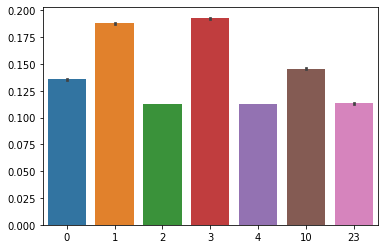

In [46]:
import seaborn as sns
sns.barplot(data=res)